We will solve the harmonic oscillator using the variance of energy approach 


In [211]:
#Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad
import torch.nn as nn
import torch.optim as optim     #optimizer
import time
import copy
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

torch.manual_seed(1234)

np.random.seed(1234)

#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device.type == 'cuda':
  print(torch.cuda.get_device_name(0))

from pyDOE import lhs #latin hypercube sampling

cuda
NVIDIA RTX A6000


In [223]:
#Second derivatives from Automatic Differentiation
#Compute the Laplacian i.e sum of s2nd derivatives across the dimensions
def laplacian(f,x):
  laplace = []
  for i in range(f.shape[1]):
    u_x = grad(f[:,i], x, grad_outputs=torch.ones_like(f[:,i]), create_graph=True, retain_graph=True)[0]
    u_xx = grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True,retain_graph=True)[0]
    laplace.append(u_xx.sum(dim=1, keepdim=True)) #Sum the 2nd derivatives across the dimensions
  laplace = torch.cat(laplace, dim=1)
  return laplace

In [224]:
#Defining the hyperparameters
class config:
  def __init__(self):
    self.t0 = -10
    self.tf = 10
    self.xbc = 0
    self.D = 1
    self.lower_bound = self.t0 * torch.ones(self.D).float()
    self.upper_bound = self.tf * torch.ones(self.D).float()
    self.vol = torch.prod(self.upper_bound - self.lower_bound)    # scalar volume of the domain
    self.eig_num = 5
    self.col_pts = 500
    self.layers = [self.D,150,150, 150,self.eig_num]
    self.epochs = 20000

cfg = config()

In [225]:
#Defining the Parametric Solution
#This enforces the solution on the boundaries
def parametricSolutions(t, nn, cfg):
    N1 = nn(t)                                    # (batch, K)
    # compute both factors for each column, then take their product
    f = ((1 - torch.exp(-(t - cfg.t0))) * (1 - torch.exp(  t - cfg.tf))) # → (batch, dim)
    f = f.prod(dim=1, keepdim=True)   # → (batch, 1)
    psi_hat = cfg.xbc + f * N1        # broadcast (batch,1)*(batch,K)
    return psi_hat

In [226]:
def hamEqs_Loss(psi, lap, v): #Defines the PDE loss
    # Hamiltonian applied to psi
    hamEqs = -0.5 * lap + v * psi
    #Multi carlo integration
    numerator = cfg.vol * (psi * hamEqs).mean(dim = 0)
    denominator = cfg.vol * (psi * psi).mean(dim = 0)
    E = numerator / denominator
    # Residual (Schrödinger equation)|
    res = 0.5 *lap + (E - v) * psi

    #variance of energy
    VoE = cfg.vol * (hamEqs**2).mean(dim = 0) - numerator**2
    
    return res, E, VoE

In [227]:
#The Harmonic potential
def pot(t):
    return 0.5 * (t.pow(2).sum(dim=1, keepdim=True))

In [228]:
#Defining the Frobenius norm
def frobenius_norm(G):
    I = torch.eye(G.shape[0], device = device, dtype = G.dtype)
    loss = torch.linalg.matrix_norm(G - I) #The frobenius norm
    return loss

#Defining the monotonicity_penalty, this is to ensure that the eigenpairs are learned monotonically
def monotonicity_penalty(E, margin = 0.0):
    diffs = E[:-1] - E[1:] + margin
    penalty = torch.relu(diffs).sum()    #torch.where(diffs > 0, torch.zeros_like(diffs), torch.exp(-diffs)).sum()       #
    return penalty

#Defining the cosine matrix
def cosine_matrix(psi,x):
  psi_norm = torch.sqrt(cfg.vol * (psi * psi).mean(dim = 0))  # (k,)
  psi_normalized = psi / psi_norm  # (n, k)
  psi_prod = psi_normalized.unsqueeze(2) * psi_normalized.unsqueeze(1)  # (n, k, k)
  cos_matrix = cfg.vol * psi_prod.mean(dim=0)   # → (K, K)
  return cos_matrix

#Norm loss to ensure the wavefunctions are properly scaled
def norm_loss(psi,x,cfg):
  psi_norm = torch.sqrt(cfg.vol * (psi * psi).mean(dim = 0))  # (k,)
  scale_term = (cfg.tf - cfg.t0)*psi_norm/cfg.col_pts
  return torch.sum((1-scale_term).pow(2))

#Norm loss to enforce orthonormality
def new_norm_loss(psi,x,cfg):
    psi_norm = (cfg.vol * (psi * psi).mean(dim = 0) - 1)**2
    return psi_norm

In [229]:
#Defining the NN architecture without symmetry
class qNN(torch.nn.Module):
  def __init__(self,cfg):
    super(qNN,self).__init__()
    self.activation = torch.sin
    self.layers = cfg.layers

    #Defining the Layers
    self.linears = nn.ModuleList([nn.Linear(self.layers[i], self.layers[i+1]) for i in range(len(self.layers) - 1)])

    #Initializing the weights
    for i in range(len(self.layers)-1):
      nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
      nn.init.zeros_(self.linears[i].bias.data)

  #Defining the forward pass
  def forward(self,x):
    if torch.is_tensor(x) != True:
      x = torch.from_numpy(x)
    a = x.float()
    #In1 = self.ein(torch.ones_like(a))
    for i in range(len(self.linears)-1):
      z = self.linears[i](a)
      #a = self.activation(z)
      if i == 0:
        a = self.activation(20*z) #Multiplying the input by a weight as recommended by the paper SIREN
      else:
        a = self.activation(z)
    a = self.linears[-1](a)
    return a

### Learning rate finder

In [230]:
#We want to find the best lr for our defined model
model_lr = qNN(cfg).to(device)
optimizer_lr = optim.Adam(model_lr.parameters(), lr=1e-7)

In [231]:
def common_train_step(NN,t_rand,vx, cfg):
    #Getting the parametric solution
    psi =parametricSolutions(t_rand,NN,cfg) #The forward pass
    psi = psi.to(device)

    # Compute second derivatives
    psi_xx = laplacian(psi,t_rand)

    L,E,VoE = hamEqs_Loss(psi,psi_xx,vx)
    Loss = torch.nn.MSELoss()
    #Getting the losses after each forward pass
    pde_loss = Loss(L,torch.zeros_like(L))  #The scaled pde_loss
    n_loss = norm_loss(psi,t_rand,cfg)
    G = cosine_matrix(psi, t_rand)
    cosine_loss = frobenius_norm(G)
    var_loss = torch.sum(VoE)
    return pde_loss, n_loss, cosine_loss,var_loss, E

In [232]:
#Training points
x_lhs = cfg.lower_bound + (cfg.upper_bound - cfg.lower_bound) * torch.tensor(lhs(cfg.D, cfg.col_pts)).float()
x_lhs.shape

torch.Size([500, 1])

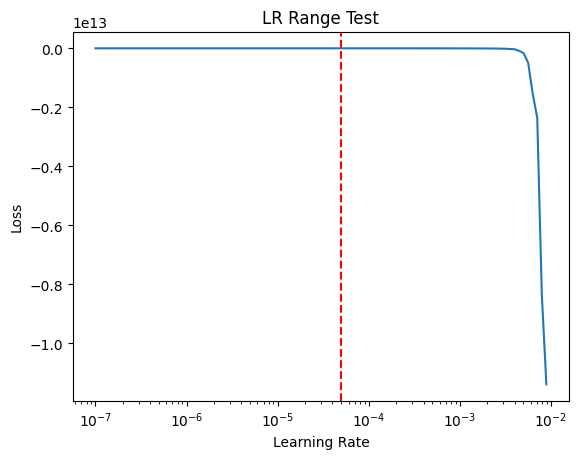

In [233]:
losses = []
lrs = []

x_lhs = x_lhs.to(device)
vx = pot(x_lhs).to(device)

start_lr = 1e-7
end_lr = 0.01
num_iter = 100
lr_mult = (end_lr / start_lr) ** (1/num_iter)

lr = start_lr

for iteration in range(num_iter):
    x_lhs.requires_grad = True
    optimizer_lr.param_groups[0]['lr'] = lr

    optimizer_lr.zero_grad()
    pde_loss, n_loss, cosine_loss,var_loss, En= common_train_step(model_lr,x_lhs,vx,cfg)
    monotone_loss =monotonicity_penalty(En, margin = 0.1)
    loss = pde_loss + n_loss+ cosine_loss + monotone_loss + var_loss
    loss.backward()

    optimizer_lr.step()

    lrs.append(lr)
    losses.append(loss.item())

    lr *= lr_mult  # increase learning rate exponentially

# Plot the result
plt.plot(lrs, losses)
plt.xscale('log')
plt.axvline(x=5e-5, color='red', linestyle='--')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('LR Range Test')
plt.show()

In [ ]:
model = qNN(cfg)
model.to(device)
print(model)
#params = list(model.parameters())
betas = [0.999, 0.9999]
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=betas)

cfg.update = 3000

qNN(
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=150, bias=True)
    (1-2): 2 x Linear(in_features=150, out_features=150, bias=True)
    (3): Linear(in_features=150, out_features=5, bias=True)
  )
)


In [ ]:
pn = []
for i in range(1, cfg.eig_num+1):
    if 

tensor([1, 2, 3, 4, 5])

In [ ]:
def nn_train(NN,t,cfg):
  En_history = [] #To store the eigenvalues as it is optimized
  loss_dic = {'pde_loss_hist': [], 'cos_loss_hist': [], 'norm_loss':[], 'total_loss_hist': [], 'lr_history': []} #To store the losses

  #pn = torch.arange(1,cfg.eig_num+1) #Sequence from 1 to number of eigenvalues
  #gaussian = fg(t, pn).to(device) #Gaussians with increasing width

  t_rand = t.to(device).float()


  #Obtaining the potential
  vx = pot(t_rand).to(device)

  #Dictionary to store the final training
  dic = {}

  stime = time.time()
  for iter in range(cfg.epochs + 1):
    t_rand.requires_grad = True
    optimizer.zero_grad()

    criteria_loss,n_loss, cosine_loss,En = common_train_step(NN,t_rand,vx,cfg)
    monotone_loss = monotonicity_penalty(En, margin = 0.1)
    total_loss = criteria_loss + n_loss + cosine_loss + monotone_loss
    En_history.append(En.cpu().detach().numpy())
    loss_dic['pde_loss_hist'].append(criteria_loss.item())
    loss_dic['cos_loss_hist'].append(cosine_loss.item())
    loss_dic['norm_loss'].append(n_loss.item())
    if iter % 200 == 0:
      print('--------------------------------------------')
      print(f'Epoch: {iter}')
      print(f'En: {En_history[-1]}')
      print('--------------------------------------------')
      print('Total_loss: ',total_loss.item())
      print('pde_loss: ',criteria_loss.item())
      print('norm_loss: ',n_loss.item())
      print('cos_loss: ',cosine_loss.item())
      print('Monotone_loss: ', monotone_loss.item())


    #Backward propagation
    total_loss.backward()



    optimizer.step()

    #Storing the loss after each iteration
    loss_dic['total_loss_hist'].append(total_loss.cpu().detach().numpy())

  #Storing the final eigenfunction
  dic[1] = copy.deepcopy(NN)


  ftime = time.time()
  ttime = (ftime - stime)/60
  print(f'Total training time is {ttime} minutes')
  return loss_dic, np.array(En_history), dic